# Time Series Data with the Howso Engine

## Overview

Time series analysis can provide users with a method of modeling temporal data to understand trends over time. The Engine can be used to forecast series data or make predictions at specific timesteps. When using the Howso Engine for time-series analysis, series are represented as a set of cases with a matching series ID. 

This recipe will demonstrate how to leverage Howso Engine's time series tools to make time series predictions.

In [1]:
from IPython.display import (
    display,
    Markdown,
)
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from howso import engine
from howso.engine import (
    Session,
    Trainee,
)
from howso.utilities import infer_feature_attributes

## Step 1: Load Data

The data we will be using is an example set of time series data for three stocks.

In [2]:
df = pd.read_csv('../../../data/example_timeseries.csv')
df

,ID,f1,f2,f3,date
0,31855,245.470,262.970,244.950,2010-01-31
1,31855,253.030,254.790,238.610,2010-02-28
2,31855,268.290,271.060,253.030,2010-03-31
3,31855,273.260,281.210,268.290,2010-04-30
4,31855,251.150,277.590,239.430,2010-05-31
...,...,...,...,...,...
4751,164306,3318.488,3318.488,3227.954,2019-04-30
4752,164306,3103.766,3323.469,3103.766,2019-05-31
4753,164306,3321.692,3332.855,3096.812,2019-06-30
4754,164306,3371.001,3418.161,3345.877,2019-07-31


Plot data for visual understanding

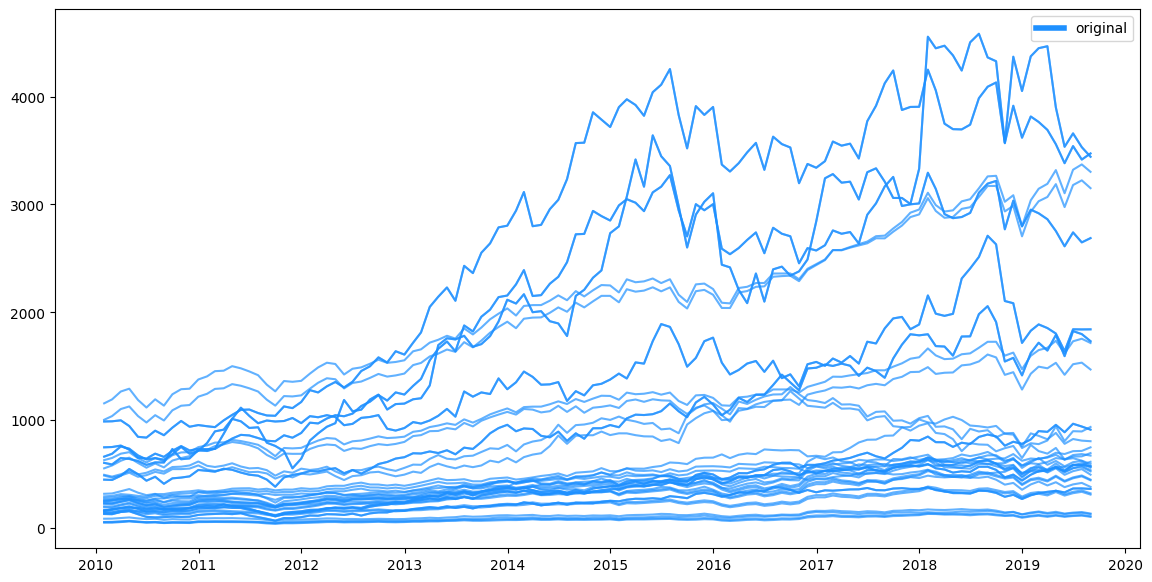

In [3]:
# Convert "date" column to `datetime` type.
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for series_id in df["ID"].unique():
    series_df = df.loc[df['ID'] == series_id].sort_values(by="date")
    ax.plot(series_df['date'], series_df['f1'], c="dodgerblue", alpha=0.7)

legend_elements = [
    Line2D([0], [0], color="dodgerblue", lw=4, label="original")
]

ax.legend(handles=legend_elements)

plt.show()

## Step 2: Define the Feature Attributes

The feature attributes must be defined whenever using the Howso Engine. When we use `infer_feature_attributes` for time-series data, it is crucial that both the `time_feature_name` and `id_feature_name` parameters are specified correctly.

Additionally, we print out the resulting feature attributes. It is important to verify feature attributes are correct.

In [4]:
# Identify id-feature and time-feature
id_feature_name = "ID"
time_feature_name = "date"
features = infer_feature_attributes(
    df,
    time_feature_name=time_feature_name,
    id_feature_name=id_feature_name
)

features.to_dataframe()

type   date_time_format decimal_places     bounds  \
                                                   allow_null   
ID       nominal                NaN            0.0      False   
f1    continuous                NaN            4.0       True   
f2    continuous                NaN            4.0       True   
f3    continuous                NaN            4.0       True   
date  continuous  %Y-%m-%dT%H:%M:%S            NaN      False   

                                                                     \
                      min                  max         observed_min   
ID                    NaN                  NaN                  NaN   
f1                      0            7530.1287               38.778   
f2                      0            7861.4348              42.0278   
f3                      0            7439.1083              36.7147   
date  2003-11-14T02:58:57  2025-11-16T21:01:02  2010-01-31T00:00:00   

                                     data_type id_feature original_type       \
             observed_max                                     data_type size   
ID                    NaN               number       True       integer  8.0   
f1              4582.5119               number        NaN       numeric  8.0   
f2              4784.7379               number        NaN       numeric  8.0   
f3              4526.4934               number        NaN       numeric  8.0   
date  2019-08-31T00:00:00  formatted_date_time        NaN      datetime  NaN   

     time_series                                                     \
            type                 rate_max                  rate_min   
ID           NaN                      NaN                       NaN   
f1          rate  [0.0012430732030380078]  [-0.0007645089495998057]   
f2          rate   [0.001388600638608105]  [-0.0006637496387383802]   
f3          rate  [0.0011805197298037438]  [-0.0005973067076699289]   
date       delta                      NaN                       NaN   

                                                             
     time_feature            delta_max            delta_min  
ID            NaN                  NaN                  NaN  
f1            NaN                  NaN                  NaN  
f2            NaN                  NaN                  NaN  
f3            NaN                  NaN                  NaN  
date         True  [7280646.049344706]  [889973.9440819533]

## Step 3: Train a Trainee and Analyze

The one change between regular analysis using non-time series data and time series data is that during the `train` call, Engine calculates time information (deltas and rates) for each feature and adds this information in as additional features in your dataset. 

**So, to utilize these new features which contain time information within the prediction, they have to be called as context features. 
The names of these features can be obtained after the `train` call using the `get_cases` call. Then, these can be passed in as context features to the `analyze` and `react` calls to make a time series prediction.**

In [5]:
# Create the Trainee
t = Trainee(
    features=features,
    overwrite_existing=True
)

session1 = Session('train_session_1', metadata={'data': 'training data'})

# Train
t.train(df)

# Store actual record data which includes all of the ts information
cases_df = t.get_cases(
    session=session1
)

# Print out ts information
cases_df

,.date_delta_1,.date_lag_1,.f1_lag_1,.f1_rate_1,.f2_lag_1,.f2_rate_1,.f3_lag_1,.f3_rate_1,.series_progress,.series_progress_delta,ID,date,f1,f2,f3
0,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.008696,31855,2010-01-31,245.470,262.970,244.950
1,2419200.0,2010-01-31T00:00:00,245.470,0.000003,262.970,-0.000003,244.950,-0.000003,0.008002,0.008002,31855,2010-02-28,253.030,254.790,238.610
2,2678400.0,2010-02-28T00:00:00,253.030,0.000006,254.790,0.000006,238.610,0.000005,0.016862,0.008860,31855,2010-03-31,268.290,271.060,253.030
3,2592000.0,2010-03-31T00:00:00,268.290,0.000002,271.060,0.000004,253.030,0.000006,0.025436,0.008574,31855,2010-04-30,273.260,281.210,268.290
4,2678400.0,2010-04-30T00:00:00,273.260,-0.000008,281.210,-0.000001,268.290,-0.000011,0.034296,0.008860,31855,2010-05-31,251.150,277.590,239.430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4751,2592000.0,2019-03-31T00:00:00,3191.164,0.000049,3215.505,0.000040,3092.292,0.000052,0.964847,0.008574,164306,2019-04-30,3318.488,3318.488,3227.954
4752,2678400.0,2019-04-30T00:00:00,3318.488,-0.000080,3318.488,0.000002,3227.954,-0.000046,0.973707,0.008860,164306,2019-05-31,3103.766,3323.469,3103.766
4753,2592000.0,2019-05-31T00:00:00,3103.766,0.000084,3323.469,0.000004,3103.766,-0.000003,0.982281,0.008574,164306,2019-06-30,3321.692,3332.855,3096.812
4754,2678400.0,2019-06-30T00:00:00,3321.692,0.000018,3332.855,0.000032,3096.812,0.000093,0.991140,0.008860,164306,2019-07-31,3371.001,3418.161,3345.877


Here, you can see the ts information that was added to the feature set when the data was trained into Engine. It is important that these time series features are added as context features for `analyze` and `react`.

## Step 4: Measure Trainee Accuracy

Below we do a typical `get_prediction_stats` to measure how well the Trainee can predict different feature values of the trained cases.

In [6]:
# Specify Context and Action Features
action_features = ['f1']
context_features = cases_df.columns.drop(action_features).to_list()

# Targeted Analysis
t.analyze(context_features=context_features, action_features=action_features)

# Calculate overall error metrics
results = t.get_prediction_stats(
    action_feature=action_features[0],
    details={"prediction_stats": True}
)

results['f1']

/home/runner/.local/lib/python3.9/site-packages/howso/direct/client.py:375: HowsoWarning: It is recommended to use a "targetless" analysis of the data for a time-series Trainee. Please analyze the data once more with no action features specified and the value "targetless" specified for the "targeted_model" parameter.
  warnings.warn(w, category=HowsoWarning)


mae                       16.929295
mcc                             NaN
smape                      3.172312
recall                          NaN
rmse                      44.212110
spearman_coeff             0.997392
missing_value_accuracy          NaN
accuracy                        NaN
r2                         0.997622
adjusted_smape             3.172311
precision                       NaN
Name: f1, dtype: float64

## Step 5: Generate Series Data Generatively

The prediction stats above were obtained using discriminative predictions. Now, we will use a generative `react_series` to forecast numerous series. For this, we will set the `desired_conviction` to be one, which indicates average surprisal for the generated cases.

Here, we are utilizing generative reacts on the entire dataset to generate predictions for each series. This is done by providing the first case of each series and generating the rest. This is done using the `series_context_features` and `series_context_values` parameters of `react_series` with the `continue_series` flag.

Time series may also be generated without providing conditions like this. 

In [7]:
action_features = df.columns.tolist()

series_context_features = df.columns.tolist()
series_context_values = []
for id in df.ID.unique():
    # Create a list of the lists containing just the first row of each series
    # in the original data. The Engine will forecast based on these first rows.
    series_context_values.append([df[df.ID == id].iloc[0].values.tolist()])

# Perform generative react
series_output =  t.react_series(
    action_features=action_features,
    series_context_features=series_context_features,
    series_context_values=series_context_values,
    continue_series=True,
    final_time_steps= ['2019-07-31T00:00:00'],
    desired_conviction=1,
    generate_new_cases='always',
    num_series_to_generate=len(series_context_values),
    series_id_tracking = 'fixed',
    series_index=None,
)
result_gen = series_output['action']


In [8]:
series_output['action']

,ID,f1,f2,f3,date
0,3909539185037899776,253.0814,254.7344,238.5669,2010-02-28 04:33:52.661948
1,3909539185037899776,276.9058,271.5581,248.6958,2010-03-31 18:30:56.986578
2,3909539185037899776,292.8623,265.8416,266.8529,2010-04-30 17:45:06.518225
3,3909539185037899776,284.0115,251.7020,251.5277,2010-05-31 18:12:00.130202
4,3909539185037899776,278.6251,232.3920,263.7327,2010-06-30 21:50:35.899665
...,...,...,...,...,...
4697,5916153458645343232,5213.6965,3831.5351,5468.9552,2019-04-01 01:16:42.479122
4698,5916153458645343232,4746.2295,3921.5203,5347.6153,2019-05-01 03:35:53.142872
4699,5916153458645343232,4212.1135,4204.5474,4878.3290,2019-06-01 08:43:07.643628
4700,5916153458645343232,4367.6612,3940.8818,4876.0332,2019-07-01 12:09:52.725758


And lastly, let's visualize our generated series data to compare it to the original trained data.

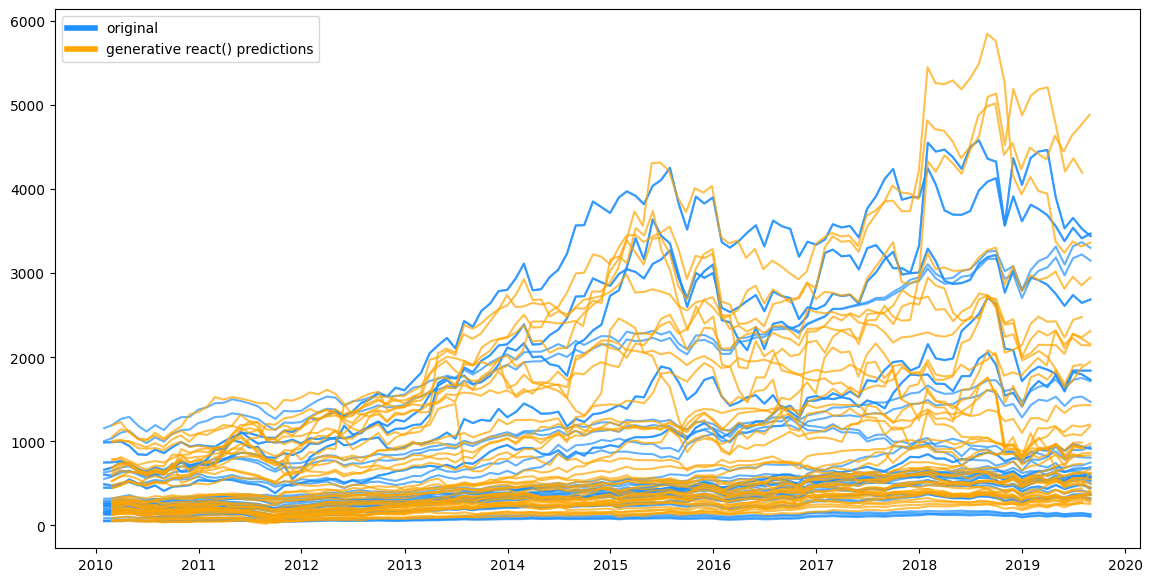

In [9]:
# Convert "date" column to `datetime` type.
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for series_id in df["ID"].unique():
    series_df = df.loc[df['ID'] == series_id].sort_values(by="date")
    ax.plot(series_df['date'], series_df['f1'], c="dodgerblue", alpha=0.7)

for series_id in result_gen["ID"].unique():
    result_df = result_gen.loc[result_gen['ID'] == series_id].sort_values(by="date")
    ax.plot(result_df['date'], result_df['f1'], c="orange", alpha=0.7)


legend_elements = [
    Line2D([0], [0], color="dodgerblue", lw=4, label="original"),
    Line2D([0], [0], color="orange", lw=4, label="generative react() predictions"),
]

ax.legend(handles=legend_elements)

plt.show()

# Note: The first case in each time series is not graphed as it is provided and thus not generated

## Step 6: Predict Stationary Feature Values of a Series

Stationary features are features whose values do not change over time in a series. When training time-series data into the Howso Engine, stationary features should have the same value for every timestep in the same series. 

In this dataset, the only stationary feature is the ID feature, since the values of F1, F2, F3, and date can change with each timestep of a series.

Stationary features can be predicted using `react_series_stationary`, which allows users to predict stationary feature values for specified trained series or given untrained series data. Below we demonstrate how one could take a previously generated series and predict the most likely ID that would correspond to this series as a whole.

In [10]:
query_series_id = result_gen["ID"].unique()[0]
query_series_df = result_gen.loc[result_gen['ID'] == query_series_id].sort_values(by="date")

# The series to have its ID value predicted
# (The ID value seen here is a randomized int from the Engine, since this is a generated series)
query_series_df

,ID,f1,f2,f3,date
0,3909539185037899776,253.0814,254.7344,238.5669,2010-02-28 04:33:52.661948
1,3909539185037899776,276.9058,271.5581,248.6958,2010-03-31 18:30:56.986578
2,3909539185037899776,292.8623,265.8416,266.8529,2010-04-30 17:45:06.518225
3,3909539185037899776,284.0115,251.7020,251.5277,2010-05-31 18:12:00.130202
4,3909539185037899776,278.6251,232.3920,263.7327,2010-06-30 21:50:35.899665
...,...,...,...,...,...
110,3909539185037899776,325.2215,356.7702,393.4561,2019-04-28 16:14:42.097375
111,3909539185037899776,326.5322,356.5606,391.3815,2019-05-30 03:59:16.243576
112,3909539185037899776,354.7530,349.9659,397.9571,2019-06-29 00:30:52.059409
113,3909539185037899776,350.3982,353.9911,418.7234,2019-07-30 01:53:56.924733


In [11]:
series_context_features = ["date", "f1", "f2", "f3"]

stationary_reaction = t.react_series_stationary(
    series_context_features=series_context_features,
    series_context_values=[query_series_df[series_context_features]],
    context_features=series_context_features,
    action_features=['ID'],
)

# The resulting predicted ID
stationary_reaction['action']

,ID
0,129800


# Summary

In this recipe we demonstrate how to do some general purpose time-series analysis using the Howso Engine. We discuss how to properly configure the feature attributes, measure Trainee accuracy, generate more series data, and predict stationary feature values.